In [1]:
import pandas as pd
import matplotlib.pyplot as plt

import matplotlib.ticker as ticker
from sklearn.preprocessing import LabelEncoder

In [2]:
df= pd.read_csv('compras_2019.csv')
data=df.copy()

## Codificar varibles categoricas

In [4]:

columns_to_drop = ['FACT-NUE-FO', 'CONCEPTO', 'FECHA', 'Hoja', 'Mes', 'CONTRATO','RFC']
data = data.drop(columns=columns_to_drop)



In [5]:
data.dtypes

PROV              int64
BENEFICIARIO     object
TIPO_OP          object
FDO-#OP         float64
TOTAL_EGRESO    float64
dtype: object

In [6]:
for i, column in enumerate(list([str(d) for d in data.dtypes])):
    if column == "object":
        data[data.columns[i]] = data[data.columns[i]].fillna(data[data.columns[i]].mode()[0])
        data[data.columns[i]] = data[data.columns[i]].astype("category").cat.codes
    else:
        data[data.columns[i]] = data[data.columns[i]].fillna(data[data.columns[i]].median())


In [7]:
data.dtypes

PROV              int64
BENEFICIARIO      int16
TIPO_OP            int8
FDO-#OP         float64
TOTAL_EGRESO    float64
dtype: object

## RANDOM FOREST

In [9]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

In [10]:
y=data.pop('TOTAL_EGRESO')

In [11]:
X=data.copy()

In [12]:
X

,PROV,BENEFICIARIO,TIPO_OP,FDO-#OP
0,206273,1786,1,260000021.0
1,206273,1786,1,260000022.0
2,206273,1786,1,262000019.0
3,206273,1786,1,262000020.0
4,112917,1782,0,1100331.0
...,...,...,...,...
20697,203016,1771,0,1102565.0
20698,203016,1858,0,1102587.0
20699,203016,1859,0,1102566.0
20700,203016,1867,0,1102567.0


In [13]:
y

0           22455.00
1        22000000.00
2           57957.14
3           66692.24
4            3048.07
            ...     
20697       89042.85
20698       86650.55
20699       86650.55
20700      176451.54
20701      144173.79
Name: TOTAL_EGRESO, Length: 20702, dtype: float64

## Dividir los datos 

In [15]:
print(data.dtypes)

PROV              int64
BENEFICIARIO      int16
TIPO_OP            int8
FDO-#OP         float64
dtype: object


In [16]:

print(X.shape, y.shape)  # Verifica que tengan el mismo número de filas


(20702, 4) (20702,)


In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [18]:
clf = RandomForestRegressor(n_estimators=1000, max_depth = 4)

In [19]:
clf.fit(X_train,y_train)

RandomForestRegressor(max_depth=4, n_estimators=1000)

In [20]:
r2_score(y_test, clf.predict(X_test))

0.30951091168607403

# NO SUPERVISADO

In [22]:
import warnings
warnings.filterwarnings("ignore",category=UserWarning,module="sklearn")
from sklearn.cluster import KMeans

In [23]:
df_copy=df.copy()

In [24]:
df.dtypes

PROV              int64
BENEFICIARIO     object
RFC              object
FACT-NUE-FO      object
CONTRATO         object
CONCEPTO         object
TIPO_OP          object
FDO-#OP         float64
FECHA            object
TOTAL_EGRESO    float64
Hoja             object
Mes              object
dtype: object

In [25]:
df_copy_group=df_copy.groupby('BENEFICIARIO').agg({'CONTRATO':lambda x:x.nunique(),'TOTAL_EGRESO':'sum','FACT-NUE-FO':lambda x:x.nunique()})

In [26]:
df_cluster=df_copy_group.reset_index().drop(['BENEFICIARIO'], axis=1)
df_cluster

,CONTRATO,TOTAL_EGRESO,FACT-NUE-FO
0,18,6164253.38,18
1,1,3840.30,1
2,1,14085942.81,1
3,3,524970.00,12
4,1,55000.00,1
...,...,...,...
1952,1,1100.00,1
1953,1,18747.99,1
1954,1,7998892.84,4
1955,1,8000.00,1


In [27]:
# normalizar
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
normalized_data = scaler.fit_transform(df_cluster)

# Convert back to a DataFrame for better visualization
df_cluster_nor = pd.DataFrame(normalized_data, columns=df_cluster.columns)
df_cluster_nor

,CONTRATO,TOTAL_EGRESO,FACT-NUE-FO
0,0.013855,4.264691e-03,0.010119
1,0.000000,2.609112e-06,0.000000
2,0.000000,9.745313e-03,0.000000
3,0.001630,3.631527e-04,0.006548
4,0.000000,3.800395e-05,0.000000
...,...,...,...
1952,0.000000,7.132352e-07,0.000000
1953,0.000000,1.292300e-05,0.000000
1954,0.000000,5.533987e-03,0.001786
1955,0.000000,5.487001e-06,0.000000


In [28]:
wcss = []

# Probar diferentes números de clusters de 1 a 10
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, max_iter=300, random_state=42)
    kmeans.fit(df_cluster_nor)  # Reemplaza con tu DataFrame normalizado
    wcss.append(kmeans.inertia_)

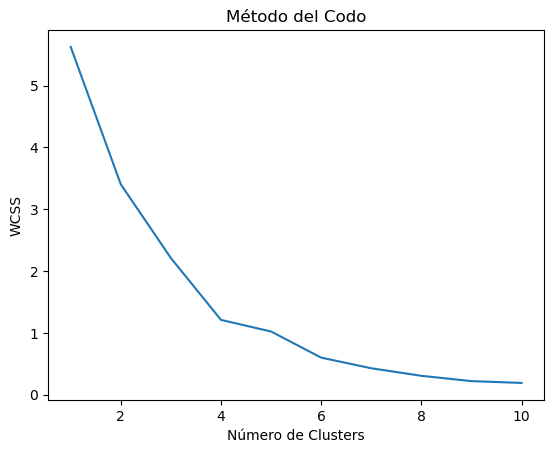

In [29]:
# Graficar el método del codo (Elbow Method)
plt.plot(range(1, 11), wcss)
plt.title('Método del Codo')
plt.xlabel('Número de Clusters')
plt.ylabel('WCSS')  # Suma de las distancias al cuadrado dentro de los clusters
plt.show()


In [30]:
clustering=KMeans(n_clusters=3,max_iter=300)

In [31]:
clustering.fit(df_cluster_nor)

KMeans(n_clusters=3)

In [32]:
df_cluster['kmeans_c']=clustering.labels_

In [33]:
df_cluster['kmeans_c'].value_counts()

kmeans_c
0    1932
1      24
2       1
Name: count, dtype: int64

## PCA

In [35]:
from sklearn.decomposition import PCA

In [36]:
pca=PCA(n_components=2)

In [37]:
pca_com=pca.fit_transform(df_cluster_nor)

In [38]:
pca_com_df=pd.DataFrame(data=pca_com,columns=['componente_1','componente_2'])

In [39]:
pca_nom_bene=pd.concat([pca_com_df,df_cluster['kmeans_c']],axis=1)

In [40]:
pca_nom_bene

,componente_1,componente_2,kmeans_c
0,0.009936,0.000342,0
1,-0.006899,-0.001616,0
2,-0.005979,0.007975,0
3,-0.000730,-0.001426,0
4,-0.006895,-0.001581,0
...,...,...,...
1952,-0.006899,-0.001617,0
1953,-0.006898,-0.001605,0
1954,-0.004976,0.003862,0
1955,-0.006898,-0.001613,0


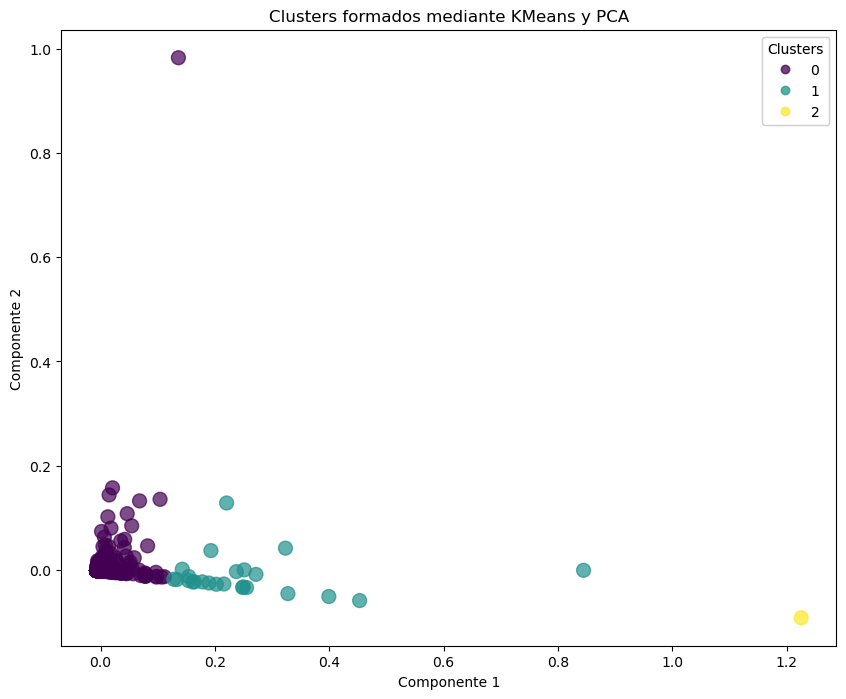

In [54]:
plt.figure(figsize=(10, 8))

scatter = plt.scatter(
    pca_nom_bene['componente_1'], 
    pca_nom_bene['componente_2'], 
    c=pca_nom_bene['kmeans_c'], 
    cmap='viridis', 
    s=100, 
    alpha=0.7
)
plt.title('Clusters formados mediante KMeans y PCA')
plt.xlabel('Componente 1')
plt.ylabel('Componente 2')

lege=plt.legend(*scatter.legend_elements(),title='Clusters')
plt.gca().add_artist(lege)

## GMM